# **Notebook 3: Machine Learning Model**

## Objectives

* Create ML model for predicting future CO2 levels based on current data

## Inputs

* clean_data.csv produced by Notebook 1

## Outputs

* Generates a predictive ML model for use with climate data



---

# Import Packages and Data

Import packages needed to run this notebook

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Import cleaned dataset

In [54]:
#set path to clean data file
path = "../raw_data/clean_data.csv"

# read data into dataframe
df_clean = pd.read_csv(path, parse_dates=['year'])

# display data types for verification
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2842 entries, 0 to 2841
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   country                     2842 non-null   object        
 1   iso_code                    2842 non-null   object        
 2   year                        2842 non-null   datetime64[ns]
 3   primary_energy_consumption  2842 non-null   float64       
 4   co2                         2842 non-null   float64       
 5   total_ghg                   2842 non-null   float64       
 6   co2_per_capita              2842 non-null   float64       
 7   co2_per_gdp                 2842 non-null   float64       
 8   energy_per_capita           2842 non-null   float64       
 9   energy_per_gdp              2842 non-null   float64       
 10  coal_co2                    2842 non-null   float64       
 11  flaring_co2                 2842 non-null   float64     

# Using Linear Regression to Predict Global CO2 levels over time

### Create train and test data sets
First I created a dataset with the columns of interest, with values summed by year.<br>
From the visualisations I know that per capita CO2 is falling over time, but it would be good to visualise total CO2 levels as this is what the model will be predicting.<br>
(Steps modified from https://www.geeksforgeeks.org/machine-learning/step-by-step-guide-to-modeling-time-series-data-using-linear-regression/)

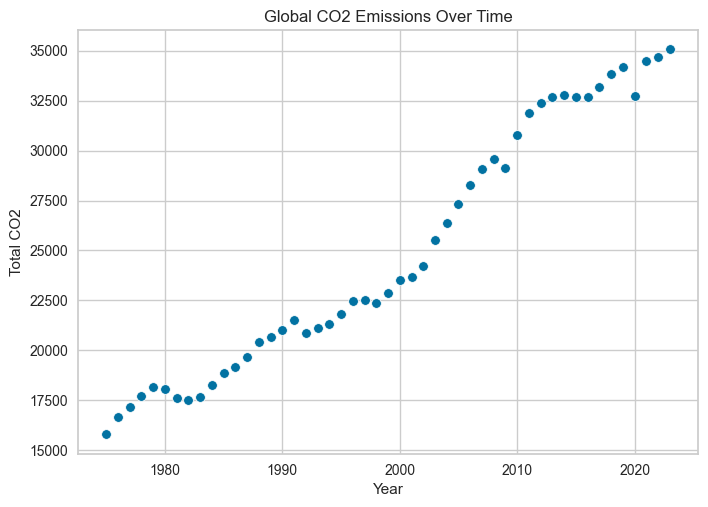

In [55]:
# create dataset with year and co2 columns only, co2 is summed across all countries
df_global = df_clean[['year', 'co2']].groupby('year', as_index=False).sum()

sns.scatterplot(df_global, x='year', y='co2')
plt.title("Global CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Total CO2")
#plt.xticks({df_global['year'] : df_global['year'].dt.year})
plt.show()

This graph shows that global CO2 levels are increasing over time.

Next I split our data into a train and test set, this lets me hold back some unseen data to test the model on after training.<br>

In [56]:
# convert year (datetime) to numeric ordinal for regression
df_global['year'] = df_global['year'].map(pd.Timestamp.toordinal)

# prepare features and target
X = df_global[['year']]
y = df_global['co2']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2, random_state=42, shuffle=False
)

print(
	"* Train set:",
	X_train.shape,
	y_train.shape,
	"\n* Test set:",
	X_test.shape,
	y_test.shape,
)

* Train set: (39, 1) (39,) 
* Test set: (10, 1) (10,)


### Model Training and Predictions
Then I can train the model on the training datasets.

In [57]:
# Initialise linear regression model
model = LinearRegression()

# Traing the model on the training sets
model.fit(X_train, y_train)

LinearRegression()

I will now make predictions for unseen data based on the trained model.

In [58]:
# Make predictions on the test data
y_pred = model.predict(X_test)

### Model Evaluation
The final step is to evaluate the model to see how well it predicts unseen data.

In [59]:
# show Mean Squared Error to evaluate model fit
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse.round(2)}')

Mean Squared Error: 1183472.49


This error value seems quite high, suggesting that out model is not predicting CO2 very accurately.<br>
Now I will plot actual versus predicted values to visualise the performance of the model.

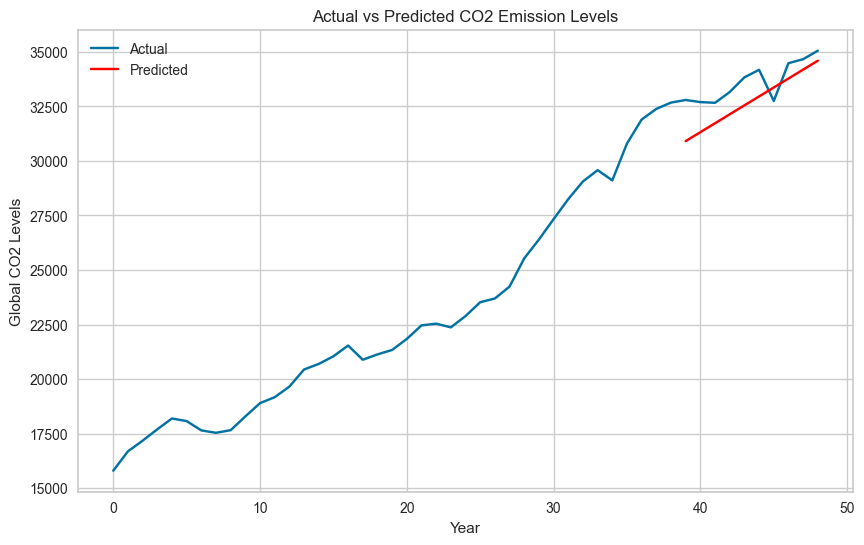

In [60]:
# Plotting the actual vs predicted values inorder to visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(df_global.index, df_global['co2'], label='Actual')
plt.plot(X_test.index, y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted CO2 Emission Levels')
plt.xlabel('Year')
plt.ylabel('Global CO2 Levels')
plt.legend()
plt.show()

This chart shows that the model is not a good predictor for CO" levels over time and is likely to underestimate future values.<br>
This suggests that CO2 emissions are more complex than a simple regression model can manage.

# Clustering Countries
This model aims to categories countries into clusters based on emissions profiles. This will allow targeted interventions for emission reductions based on which cluster a country belongs to.

### Define the Dataset
I want to train this model on the most recent data for each country, so I will create a dataframe with only records from 2023.

In [61]:
# create a dataframe with rows where year is 2023 and keep only numeric columns, missing values will be dropped
df_2023 = df_clean[df_clean['year'].dt.year == 2023].select_dtypes(include=[np.number]).dropna().copy()
print(df_2023.shape)
df_2023.head()

(57, 14)


,primary_energy_consumption,co2,total_ghg,co2_per_capita,co2_per_gdp,energy_per_capita,energy_per_gdp,coal_co2,flaring_co2,gas_co2,oil_co2,cumulative_co2,pop(m),gdp($b)
48,705.003,178.133,282.645,3.859,2.989712e-10,15458.390,1.183248e-09,0.689,15.378,92.546,59.966,5263.690,46.16,595.82
97,1019.741,195.806,422.011,4.300,2.290359e-10,22277.793,1.192800e-09,4.106,2.054,91.051,93.742,9012.649,45.54,854.91
146,1672.456,382.972,580.988,14.478,2.848964e-10,63256.879,1.244155e-09,142.666,17.140,74.636,141.596,19664.301,26.45,1344.25
195,384.811,58.578,67.949,6.416,1.468801e-10,42952.613,9.648860e-10,10.892,0.080,13.832,30.733,5693.515,9.13,398.82
244,508.489,113.427,263.614,0.662,1.321771e-10,2940.021,5.925451e-10,23.905,0.031,56.181,31.796,1922.090,171.47,858.14


### Create Cluster Pipeline
First I create a pipeline to perform feature scaling, principal component analysis (PCA) and define the model steps.

In [62]:
# Create pipeline for ML clustering model
def PipelineCluster():
  pipeline_base = Pipeline([
      # feature scaling
      ("scaler", StandardScaler()),    
      # pca
      ("PCA",  PCA(n_components=50, random_state=0)), 
      # modelling
      ("model", KMeans(n_clusters=50, random_state=0)), 
  ])
  return pipeline_base

PipelineCluster()

Pipeline(steps=[('scaler', StandardScaler()),
                ('PCA', PCA(n_components=50, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

### Determine suitable n_component value for PCA
This step helps to work out how many components to evaluate in the PCA step. <br>
First I will clean and scale the data to prepare it for PCA.

In [63]:
# create a pipeline with just the feature scaling step to prepare data for PCA
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df_2023)

print(df_pca.shape,'\n', type(df_pca))

(57, 14) 
 <class 'numpy.ndarray'>


Now I will apply PCA to the scaled data to see how much variance is explained by each component.

In [64]:
n_components = 14 # set the number of components to match number of columns in the data

pca = PCA(n_components=n_components).fit(df_pca)  # set PCA object and fit to the data
x_PCA = pca.transform(df_pca) # array with transformed PCA

# store variance information to dataframe for evaluation
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

# prints how much of the dataset these components explain which is useful for comparing different component values
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 14 components explain 100.0% of the data 

              Explained Variance Ratio (%)
Component 0                         55.286
Component 1                         19.156
Component 2                         10.797
Component 3                          9.400
Component 4                          2.165
Component 5                          1.460
Component 6                          1.048
Component 7                          0.270
Component 8                          0.244
Component 9                          0.083
Component 10                         0.062
Component 11                         0.025
Component 12                         0.004
Component 13                         0.000


This shows that most of the variance can be explained by the first few components.<br>
I will run the PCA again using only 5 components to see how well that covers the data.

In [65]:
n_components = 5

pca = PCA(n_components=n_components).fit(df_pca)  # set PCA object and fit to the data
x_PCA = pca.transform(df_pca) # array with transformed PCA

# store variance information to dataframe for evaluation
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

# prints how much of the dataset these components explain which is useful for comparing different component values
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 5 components explain 96.8% of the data 

             Explained Variance Ratio (%)
Component 0                        55.286
Component 1                        19.156
Component 2                        10.797
Component 3                         9.400
Component 4                         2.165


These five components cover over 90% of that data, so should give a good balance between coverage and performance for the model.<br>
I will now define the pipeline again, with the updated n_components value

In [66]:
# Create pipeline for ML clustering model
def PipelineCluster():
  pipeline_base = Pipeline([
      # feature scaling
      ("scaler", StandardScaler()),    
      # pca
      ("PCA",  PCA(n_components=5, random_state=0)), 
      # modelling
      ("model", KMeans(n_clusters=50, random_state=0)), 
  ])
  return pipeline_base

PipelineCluster()

Pipeline(steps=[('scaler', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

### Determine suitable number of clusters
Next I will use the elbow method and silhouette score to work out the most suitable number of clusters for the model.<br>
The first step is to prepare the data for analysis by creating a pipeline with feature scaling and PCA steps.

In [67]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_2023)

print(df_analysis.shape,'\n', type(df_analysis))

(57, 5) 
 <class 'numpy.ndarray'>


Next I will create plots to evaluate clusters using the elbow method.

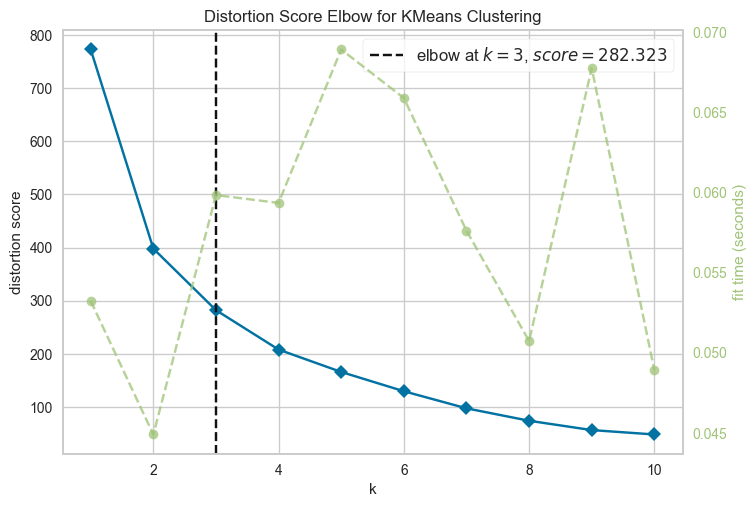

In [68]:
# define visualiser for kmeans algorithm and number of clusters to test
visualiser = KElbowVisualizer(KMeans(n_init=10, random_state=0), k=(1,11))
visualiser.fit(df_analysis) 
visualiser.show() 
plt.show()

This suggests that 3 clusters would be best.<br>
There is also a steep increase in fit time at 5 clusters, so for efficiency it would be best to stay below this number.

In [69]:
# Create pipeline for ML clustering model
def PipelineCluster():
  pipeline_base = Pipeline([
      # feature scaling
      ("scaler", StandardScaler()),    
      # pca
      ("PCA",  PCA(n_components=5, random_state=0)), 
      # modelling
      ("model", KMeans(n_clusters=3, random_state=0)), 
  ])
  return pipeline_base

PipelineCluster()

Pipeline(steps=[('scaler', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

### Fit cluster pipeline

In [70]:
# create a copy of the data for training
X = df_2023.copy()
# fit the cluster pipeline to the training data
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

# add a column to our training data for cluster predictions
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(57, 15)


c:\Users\Emily\Documents\code-institute-projects\co2-emissions\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,primary_energy_consumption,co2,total_ghg,co2_per_capita,co2_per_gdp,energy_per_capita,energy_per_gdp,coal_co2,flaring_co2,gas_co2,oil_co2,cumulative_co2,pop(m),gdp($b),Clusters
48,705.003,178.133,282.645,3.859,2.989712e-10,15458.390,1.183248e-09,0.689,15.378,92.546,59.966,5263.690,46.16,595.82,1
97,1019.741,195.806,422.011,4.300,2.290359e-10,22277.793,1.192800e-09,4.106,2.054,91.051,93.742,9012.649,45.54,854.91,1
146,1672.456,382.972,580.988,14.478,2.848964e-10,63256.879,1.244155e-09,142.666,17.140,74.636,141.596,19664.301,26.45,1344.25,1


Visualise cluster frequencies

* Clusters frequencies 
          proportion
Clusters            
1               0.77
0               0.19
2               0.04 




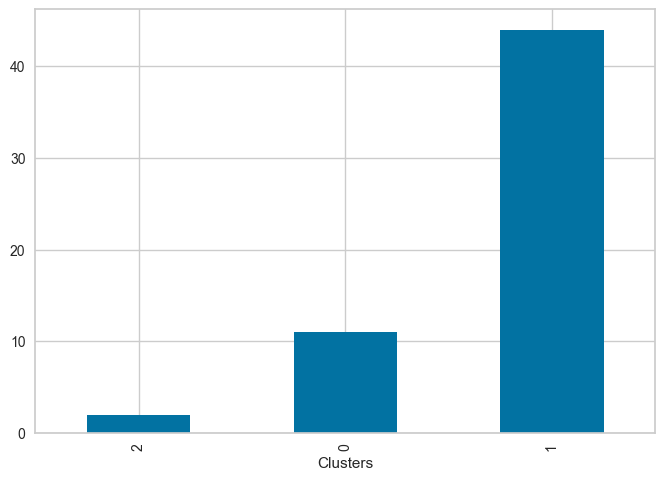

In [71]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

This shows that the clustering has split the data into very unequal clusters.<br>
This suggests that a different method of clustering is required, perhaps using the full amount of countries in the original dataset or different columns.<br>
Unfortunately this is out of scope of the current project.

---

This is the end of Notebook 3, analysis continues in the CO2 Emissions Dashboard (located in the dashboard folder, co2_emissions_dashboard.pbix)

---